In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# RNN

#### data

In [3]:
def trend_f(time,slope):
    trend=time*slope
    return trend
def season_f(time,period):
    season=(time%period)/period
    return season
def seasonality_f(sason_time,amplitude):
    data_pattern = np.where(season_time < 0.4,np.cos(season_time * 2 * np.pi),1 / np.exp(3 * season_time))
    seasonality=amplitude*data_pattern
    return seasonality
def noise_f(time,noise_level):
    rnd = np.random.RandomState(42)
    noise = rnd.randn(len(time))*noise_level
    return noise

In [4]:
slope=0.05
period=365
amplitude=40
noise_level=5
baseline=10
time=np.arange(365*4+1)

trend=trend_f(time,slope)
season_time=season_f(time,period)
seasonality=seasonality_f(season_time,amplitude)
noise = noise_f(time,noise_level)

series=baseline+noise+trend+seasonality

Text(0, 0.5, 'value')

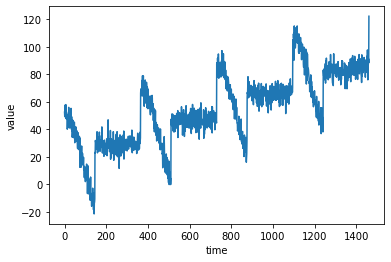

In [5]:
plt.plot(time, series)
plt.xlabel('time')
plt.ylabel('value')

In [6]:
split_time=1000
x_train=series[:split_time]
x_val=series[split_time:]
time_train=time[:split_time]
time_val=time[split_time:]

In [7]:
window=20
batch=32
shuffle_buffer=1000

In [8]:
def windowed_data(series,window,batch,shuffle_buffer):
    data=tf.data.Dataset.from_tensor_slices(series)
    data=data.window(window+1,shift=1,drop_remainder=True)
    data=data.flat_map(lambda i: i.batch(window+1))
    data=data.map(lambda i: (i[:-1], i[-1]))
    data=data.shuffle(shuffle_buffer)
    data=data.batch(batch).prefetch(1)
    return data

In [9]:
dataset=windowed_data(series,window,batch,shuffle_buffer)

In [10]:
for x,y in dataset:
  print("x = ", x.numpy())
  print("y = ", y.numpy())
  print()

x =  [[ 63.25971198  66.91809131  65.66922738  71.64629915  78.2927799
   62.95834647  63.1208468   70.7449768   68.89052666  74.67226472
   68.31678377  63.5598468   68.26948936  70.8203785   69.34064831
   67.7367098   70.49653481  70.97317463  72.00173471  68.29943422]
 [ 49.93580347  47.7832036   53.51929418  48.60548286  48.81756421
   46.27985483  47.84519675  49.70108995  39.64354145  41.48590346
   51.97574189  49.14648196  47.40511276  48.45021397  50.12910673
   45.72569158  44.56639491  87.47922628  81.65220968  88.61755981]
 [ 41.03373528  45.36450227  46.28405261  51.48868794  37.56801808
   53.69100975  45.26643912  43.93559479  41.02329838  37.82365317
   50.22819945  46.49363768  39.6922336   39.68192107  44.49395248
   54.53382656  44.90688472  38.70552656  45.00920089  44.89124603]
 [ 54.2897496   47.53197463  44.79210281  50.02538999  34.81392711
   47.03939898  49.70785172  38.45326721  51.5581106   47.52542977
   43.75057712  48.98545279  57.16998861  46.7212868   

   61.24646693  57.85536974  59.99891531  61.49212265  58.41150805]]
y =  [38.81262745 28.28000898 43.93559479 51.1850739  25.18607967 74.65343434
 40.99589594 40.93184102 55.6900167  86.74107292 86.31024391 66.88934057
 69.47453262 57.71808166 46.40745882 62.18769731 28.20581972 90.93533274
 61.11138224 22.0284378  38.77553151 57.85536974 25.13970658 32.63576266
 80.42562684 28.90339145 25.61907494 28.04865127  2.91552937 59.61281671
 68.27628039 57.76530691]

x =  [[ 88.83144694  82.92502306  76.18183647  81.75509474  83.04582641
   80.8733508   69.48581184  73.26541309  75.21934235  75.63242442
   78.64757641  75.96446484  67.92325509  76.01741217  76.67838478
   75.92618882  78.02583057  76.27930248  73.88659786  70.71428427]
 [ 43.35101175  41.51481464  40.17753568  33.87169104  37.2377144
   38.09790511  45.24254666  41.22268301  30.22901514  40.19637968
   36.17456548  34.23181292  40.18383749  41.78223419  40.77832754
   31.41360409  33.54463559  36.22142998  38.91083398  31.09

#### model

In [13]:
model=tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x,axis=-1),input_shape=[window]),
    tf.keras.layers.SimpleRNN(40,return_sequences=True),
    tf.keras.layers.SimpleRNN(40),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*100)
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_2 (Lambda)           (None, 20, 1)             0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 20, 40)            1680      
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 40)                3240      
                                                                 
 dense_1 (Dense)             (None, 1)                 41        
                                                                 
 lambda_3 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 4,961
Trainable params: 4,961
Non-trainable params: 0
_________________________________________________________________


#### tune learning rate

In [14]:
lr_schedule=tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch/20))
model.compile(optimizer=tf.keras.optimizers.SGD(momentum=0.9),loss=tf.keras.losses.Huber(),metrics=['mae'])
history=model.fit(dataset,epochs=100,callbacks=[lr_schedule])

Epoch 1/100
46/46 [==============================] - 3s 25ms/step - loss: 90.0987 - accuracy: 0.0000e+00 - lr: 1.0000e-08
Epoch 2/100
46/46 [==============================] - 0s 6ms/step - loss: 86.5854 - accuracy: 0.0000e+00 - lr: 1.1220e-08
Epoch 3/100
46/46 [==============================] - 0s 6ms/step - loss: 82.4178 - accuracy: 0.0000e+00 - lr: 1.2589e-08
Epoch 4/100
46/46 [==============================] - 0s 6ms/step - loss: 77.6205 - accuracy: 0.0000e+00 - lr: 1.4125e-08
Epoch 5/100
46/46 [==============================] - 0s 6ms/step - loss: 71.9661 - accuracy: 0.0000e+00 - lr: 1.5849e-08
Epoch 6/100
46/46 [==============================] - 0s 7ms/step - loss: 65.0183 - accuracy: 0.0000e+00 - lr: 1.7783e-08
Epoch 7/100
46/46 [==============================] - 0s 6ms/step - loss: 55.8927 - accuracy: 0.0000e+00 - lr: 1.9953e-08
Epoch 8/100
46/46 [==============================] - 0s 6ms/step - loss: 44.4235 - accuracy: 0.0000e+00 - lr: 2.2387e-08
Epoch 9/100
46/46 [============

(1e-08, 0.001, 0.0, 300.0)

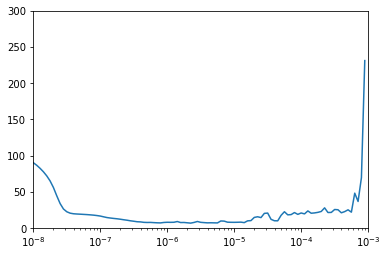

In [16]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

#### model training

In [17]:
model=tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x,axis=-1),input_shape=[window]),
    tf.keras.layers.SimpleRNN(40,return_sequences=True),
    tf.keras.layers.SimpleRNN(40),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*100)
])
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6,momentum=0.9),loss=tf.keras.losses.Huber(),metrics=['mae'])
history=model.fit(dataset,epochs=100)

Epoch 1/100
46/46 [==============================] - 1s 6ms/step - loss: 42.7611 - accuracy: 0.0000e+00
Epoch 2/100
46/46 [==============================] - 0s 6ms/step - loss: 22.2761 - accuracy: 0.0000e+00
Epoch 3/100
46/46 [==============================] - 0s 6ms/step - loss: 21.0287 - accuracy: 0.0000e+00
Epoch 4/100
46/46 [==============================] - 0s 6ms/step - loss: 19.8145 - accuracy: 0.0000e+00
Epoch 5/100
46/46 [==============================] - 0s 6ms/step - loss: 18.4056 - accuracy: 0.0000e+00
Epoch 6/100
46/46 [==============================] - 0s 7ms/step - loss: 16.3782 - accuracy: 0.0000e+00
Epoch 7/100
46/46 [==============================] - 0s 7ms/step - loss: 13.8149 - accuracy: 0.0000e+00
Epoch 8/100
46/46 [==============================] - 0s 6ms/step - loss: 9.3203 - accuracy: 0.0000e+00
Epoch 9/100
46/46 [==============================] - 0s 9ms/step - loss: 7.2511 - accuracy: 0.0000e+00
Epoch 10/100
46/46 [==============================] - 0s 6ms/step 

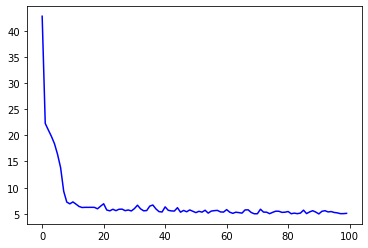

In [18]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')

#### prediciton

In [19]:
forecast = []
series_f=series[split_time-window:]
for time in range(len(series_f)-window):
  forecast.append(model.predict(series_f[time:time+window][np.newaxis]))

print(f'length of the forecast list: {len(forecast)}')
print(f'shape of the validation set: {x_val.shape}')

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step
length of the forecast list: 461
shape of the validation set: (461,)


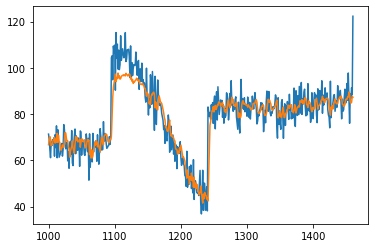

In [20]:
results=np.array(forecast).squeeze()
plt.plot(time_val, x_val)
plt.plot(time_val, results)

In [21]:
print(tf.keras.metrics.mean_squared_error(x_val, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_val, results).numpy())

49.18853
5.1733055


---

# LSTM

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def trend_f(time,slope):
    trend=time*slope
    return trend
def season_f(time,period):
    season=(time%period)/period
    return season
def seasonality_f(sason_time,amplitude):
    data_pattern = np.where(season_time < 0.4,np.cos(season_time * 2 * np.pi),1 / np.exp(3 * season_time))
    seasonality=amplitude*data_pattern
    return seasonality
def noise_f(time,noise_level):
    rnd = np.random.RandomState(42)
    noise = rnd.randn(len(time))*noise_level
    return noise

#### data

In [3]:
slope=0.05
period=365
amplitude=40
noise_level=5
baseline=10
time=np.arange(365*4+1)

trend=trend_f(time,slope)
season_time=season_f(time,period)
seasonality=seasonality_f(season_time,amplitude)
noise = noise_f(time,noise_level)

series=baseline+noise+trend+seasonality

Text(0, 0.5, 'value')

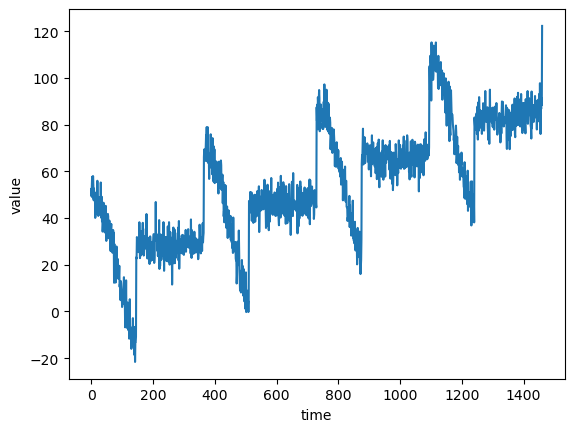

In [4]:
plt.plot(time, series)
plt.xlabel('time')
plt.ylabel('value')

In [5]:
split_time=1000
x_train=series[:split_time]
x_val=series[split_time:]
time_train=time[:split_time]
time_val=time[split_time:]

In [6]:
window=20
batch=32
shuffle_buffer=1000

In [7]:
def windowed_data(series,window,batch,shuffle_buffer):
    data=tf.data.Dataset.from_tensor_slices(series)
    data=data.window(window+1,shift=1,drop_remainder=True)
    data=data.flat_map(lambda i: i.batch(window+1))
    data=data.map(lambda i: (i[:-1], i[-1]))
    data=data.shuffle(shuffle_buffer)
    data=data.batch(batch).prefetch(1)
    return data

In [8]:
dataset=windowed_data(series,window,batch,shuffle_buffer)

In [9]:
for x,y in dataset:
  print("x = ", x.numpy())
  print("y = ", y.numpy())
  print()

x =  [[ 27.97132623  39.13112625  18.21782835  30.98221556  19.48453133
   25.18607967  32.98854898  27.86367827  22.15245816  23.96398562
   30.93822986  23.88855633  28.62323887  27.76976628  24.2852679
   38.26475077  30.71678098  17.42402011  28.48494022  24.24705717]
 [ 76.18183647  81.75509474  83.04582641  80.8733508   69.48581184
   73.26541309  75.21934235  75.63242442  78.64757641  75.96446484
   67.92325509  76.01741217  76.67838478  75.92618882  78.02583057
   76.27930248  73.88659786  70.71428427  62.22830368  72.14294758]
 [ 82.29519348  86.72619692  81.87249287  82.43751401  78.29620464
   80.53652647  78.20629494  79.88629019  89.82379094  79.58757709
   97.26461582  86.32665687  84.53092448  79.05103596  86.56995279
   79.90538644  83.09848971  94.98352354  81.387362    87.2885975 ]
 [ 20.65577173  25.61977771  28.48752315  35.05430298  20.68303577
   33.69286661  27.9432034   22.99977167  30.23339335  28.93401741
   24.95375709  28.32025175  26.06134823  28.5724506   

#### model

In [12]:
model=tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x,axis=-1),input_shape=[window]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*100)
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 20, 1)             0         
                                                                 
 bidirectional (Bidirectiona  (None, 20, 64)           8704      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
 lambda_2 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 33,601
Trainable params: 33,601
Non-traina

#### tuning learning rate

In [14]:
lr_schedule=tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch/20))
model.compile(optimizer=tf.keras.optimizers.SGD(momentum=0.9),loss=tf.keras.losses.Huber(),metrics=['mae'])
history=model.fit(dataset,epochs=100,callbacks=[lr_schedule])

Epoch 1/100
46/46 [==============================] - 13s 28ms/step - loss: 37.6192 - accuracy: 0.0000e+00 - lr: 1.0000e-08
Epoch 2/100
46/46 [==============================] - 1s 26ms/step - loss: 36.0018 - accuracy: 0.0000e+00 - lr: 1.1220e-08
Epoch 3/100
46/46 [==============================] - 1s 26ms/step - loss: 34.2154 - accuracy: 0.0000e+00 - lr: 1.2589e-08
Epoch 4/100
46/46 [==============================] - 1s 26ms/step - loss: 32.3638 - accuracy: 0.0000e+00 - lr: 1.4125e-08
Epoch 5/100
46/46 [==============================] - 1s 27ms/step - loss: 30.5377 - accuracy: 0.0000e+00 - lr: 1.5849e-08
Epoch 6/100
46/46 [==============================] - 1s 26ms/step - loss: 28.8318 - accuracy: 0.0000e+00 - lr: 1.7783e-08
Epoch 7/100
46/46 [==============================] - 2s 29ms/step - loss: 27.2506 - accuracy: 0.0000e+00 - lr: 1.9953e-08
Epoch 8/100
46/46 [==============================] - 1s 26ms/step - loss: 25.7840 - accuracy: 0.0000e+00 - lr: 2.2387e-08
Epoch 9/100
46/46 [====

(1e-08, 0.001, 0.0, 30.0)

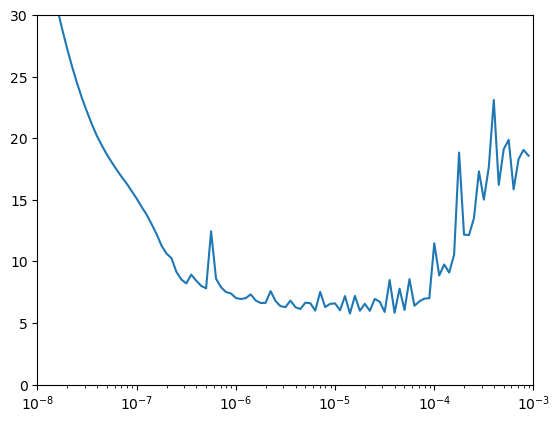

In [16]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 30])

#### model training

In [18]:
model=tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x,axis=-1),input_shape=[window]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*100)
])
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=2e-6,momentum=0.9),loss=tf.keras.losses.Huber(),metrics=['mae'])
history=model.fit(dataset,epochs=100)

Epoch 1/100
46/46 [==============================] - 12s 28ms/step - loss: 20.3761 - accuracy: 0.0000e+00
Epoch 2/100
46/46 [==============================] - 1s 27ms/step - loss: 8.8970 - accuracy: 0.0000e+00
Epoch 3/100
46/46 [==============================] - 1s 26ms/step - loss: 7.0333 - accuracy: 0.0000e+00
Epoch 4/100
46/46 [==============================] - 1s 27ms/step - loss: 6.4705 - accuracy: 0.0000e+00
Epoch 5/100
46/46 [==============================] - 1s 27ms/step - loss: 6.4113 - accuracy: 0.0000e+00
Epoch 6/100
46/46 [==============================] - 1s 27ms/step - loss: 6.1233 - accuracy: 0.0000e+00
Epoch 7/100
46/46 [==============================] - 1s 27ms/step - loss: 6.0427 - accuracy: 0.0000e+00
Epoch 8/100
46/46 [==============================] - 1s 26ms/step - loss: 5.7560 - accuracy: 0.0000e+00
Epoch 9/100
46/46 [==============================] - 1s 26ms/step - loss: 5.6206 - accuracy: 0.0000e+00
Epoch 10/100
46/46 [==============================] - 1s 27ms/

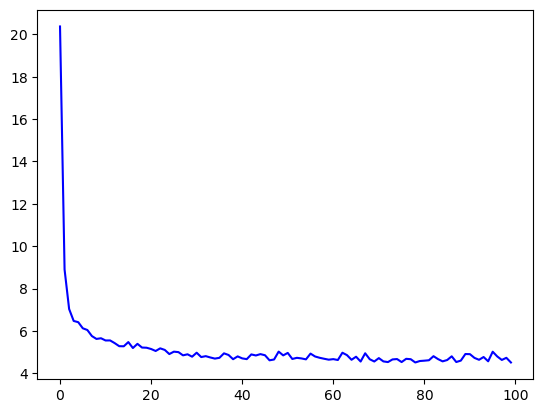

In [20]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')

#### prediction

In [21]:
def model_forecast(model, series, window_size, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    dataset = dataset.batch(batch_size).prefetch(1)
    forecast = model.predict(dataset)
    return forecast

In [23]:
forecast_series = series[split_time-window:-1]
forecast = model_forecast(model, forecast_series, window, batch)
results = forecast.squeeze()

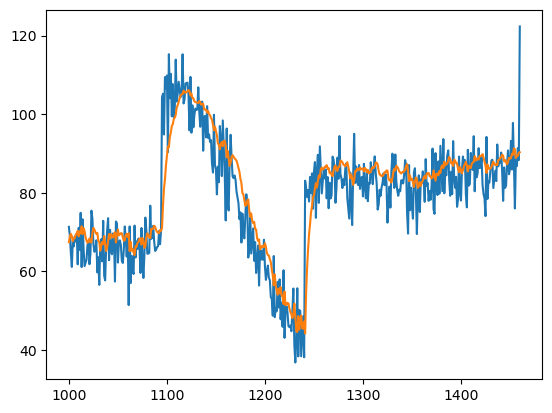

In [24]:
results=np.array(forecast).squeeze()
plt.plot(time_val, x_val)
plt.plot(time_val, results)

In [25]:
print(tf.keras.metrics.mean_squared_error(x_val, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_val, results).numpy())

55.126072
5.580728
